In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request

Create frames from each video file

In [2]:
def save_frames(frames, labels, output_dir, video_number):
    """
    Save frames as individual image files with corresponding labels.

    Args:
      frames: List of frames to be saved.
      labels: List of labels corresponding to the frames.
      output_dir: Directory where frames will be saved.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    
    for i, (frame, label) in enumerate(zip(frames, labels)):
        label_dir = os.path.join(output_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        cv2.imwrite(os.path.join(label_dir, f"video_{video_number}_frame_{i}.jpg"), cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    

def frames_from_video_file(video_path, n_frames, label, output_size=(1920, 1080), frame_step=15):
    """
    Creates frames from a video file and assigns a label to each frame.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      label: Label for the video file.
      output_size: Pixel size of the output frame image.
      frame_step: Step between consecutive frames.

    Return:
      A list of frames extracted from the video.
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    need_length = min(1 + (n_frames - 1) * frame_step, video_length)

    start = 0
    if need_length < video_length:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    for _ in range(n_frames):
        ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros((output_size[1], output_size[0], 3), dtype=np.uint8))
    src.release()

    return result

def format_frames(frame, output_size):
    """
    Resize an image from a video to the specified output size.

    Args:
      frame: Image to be resized.
      output_size: Pixel size of the output frame image.

    Return:
      Resized frame.
    """
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert frame to RGB color space
    frame_resized = cv2.resize(frame_rgb, output_size, interpolation=cv2.INTER_LINEAR)  # Resize frame
    return frame_resized


Processing the Dataset

In [12]:
# Define the directory of the video files and where to save frames
dataset_dir = "E:\\Projects\\Sign Language\\PkSLMNM"
output_dir = "E:\\Projects\\Sign Language\\PkSLMNM_Frames"

# Parameters
n_frames_per_video = 30   # Number of frames per video
output_size = (1920, 1080)  # Output frame size
frame_step = 2  # Step between consecutive frames
video_number = 1
# Process each video in the dataset
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    for video_file in os.listdir(label_dir):
        video_path = os.path.join(label_dir, video_file)
        frames = frames_from_video_file(video_path, n_frames_per_video, label, output_size, frame_step)
        save_frames(frames, [label] * n_frames_per_video, output_dir, video_number)
        video_number += 1

Making a Dataset!

In [3]:
import os
import cv2
import numpy as np
import torch
from torchvision.datasets import DatasetFolder
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

class VideoFramesDataset(DatasetFolder):
    def __init__(self, root, labels, transform=None, target_transform=None, loader=None):
        self.labels = labels
        super().__init__(root, loader, extensions=("jpg",), transform=transform, target_transform=target_transform)

    def __getitem__(self, index):
        path, target = self.samples[index]
        frames = self.load_frames(path)
        if self.transform is not None:
            frames = [self.transform(frame) for frame in frames]
        return frames, target

    def load_frames(self, path):
        frames = []
        if os.path.isdir(path):
            for frame_file in sorted(os.listdir(path)):
                frame_path = os.path.join(path, frame_file)
                print("Processing:", frame_path)  # Add this line to print the path
                frame = cv2.imread(frame_path)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                frames.append(frame)
        else:
            frame = cv2.imread(path)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            frames.append(frame)
        return frames

# Define the transform to resize frames using PIL
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize frames to (224, 224)
    transforms.ToTensor()
])

# Example usage:
video_dir = "E:\\Projects\\Sign Language\\PkSLMNM_Frames\\"
labels = ['bad', 'best', 'glad', 'sad', 'scared', 'stiff', 'surprise']  # List of labels
dataset = VideoFramesDataset(video_dir, labels, transform=transform)

# Move dataset tensors to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in tqdm(range(len(dataset))):
    frames, target = dataset[i]
    # No need to move frames to device again if already in CUDA
    frames = [frame.to(device) for frame in frames]  
    # Proceed with further processing or training


100%|██████████| 20160/20160 [20:46<00:00, 16.18it/s]


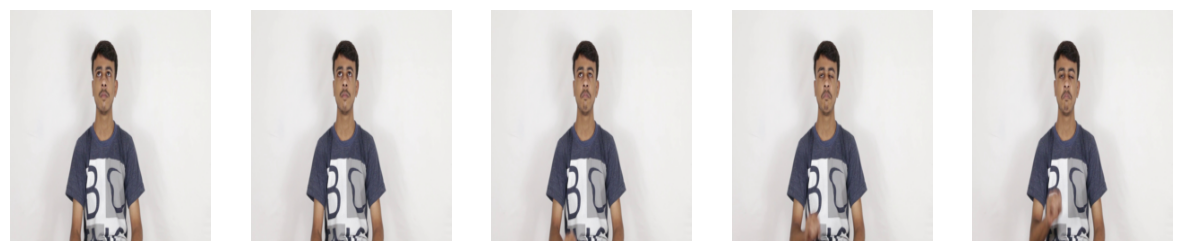

In [4]:
import matplotlib.pyplot as plt

# Display 5 images
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    frames, target = dataset[i]
    # Assuming frames is a list of tensors
    image = frames[0].permute(1, 2, 0).cpu().numpy()  # Convert tensor to NumPy array and transpose
    axs[i].imshow(image, aspect='auto')  # Display the image
    axs[i].axis('off')

plt.show()


In [5]:
import torch

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")
else:
    print("CUDA is not available, using CPU")
    device = torch.device("cpu")


CUDA is available


Downloading and Fine-Tuning ViT

In [6]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader

# Fine-tuning parameters
num_classes = 7
model_name_or_path = "google/vit-base-patch16-224-in21k"
batch_size = 32
epochs = 10
learning_rate = 1e-5

feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor


c:\Users\Ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
example = feature_extractor(dataset[1][0], return_tensors='pt')
example['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [9]:
def collate_fn(batch):
    pixel_values = torch.stack([example[0][0] for example in batch])
    labels = torch.tensor([example[1] for example in batch])
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }


In [10]:
from datasets import load_metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_19184\596144350.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
c:\Users\Ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [12]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="E:\\Projects\\Sign Language\\PkSLMNM_Model",
    per_device_train_batch_size=16,
    num_train_epochs=4,
    evaluation_strategy="steps",  # Set evaluation strategy to steps or epoch
    eval_steps=500,  # Number of steps before evaluating
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_steps=500,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)


In [13]:

# Fine-tuning parameters
num_classes = 7
# Load ViT model and feature extractor
model = ViTForImageClassification.from_pretrained(model_name_or_path, num_labels=num_classes)
model.to('cuda')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [14]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor
)

In [15]:
train_results = trainer.train()

trainer.save_model("E:\\Projects\\Sign Language\\PkSLMNM_Model")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

trainer.save_state()

c:\Users\Ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5040 [00:00<?, ?it/s]

{'loss': 1.9388, 'learning_rate': 0.0001996031746031746, 'epoch': 0.01}
{'loss': 1.9336, 'learning_rate': 0.00019920634920634922, 'epoch': 0.02}
{'loss': 1.944, 'learning_rate': 0.00019880952380952382, 'epoch': 0.02}
{'loss': 1.8338, 'learning_rate': 0.00019841269841269844, 'epoch': 0.03}
{'loss': 1.7235, 'learning_rate': 0.00019801587301587303, 'epoch': 0.04}
{'loss': 1.5635, 'learning_rate': 0.00019761904761904763, 'epoch': 0.05}
{'loss': 1.4169, 'learning_rate': 0.00019722222222222225, 'epoch': 0.06}
{'loss': 1.3211, 'learning_rate': 0.00019682539682539682, 'epoch': 0.06}
{'loss': 1.3211, 'learning_rate': 0.00019642857142857144, 'epoch': 0.07}
{'loss': 1.2495, 'learning_rate': 0.00019603174603174603, 'epoch': 0.08}
{'loss': 1.3012, 'learning_rate': 0.00019563492063492062, 'epoch': 0.09}
{'loss': 1.1779, 'learning_rate': 0.00019523809523809525, 'epoch': 0.1}
{'loss': 1.1974, 'learning_rate': 0.00019484126984126984, 'epoch': 0.1}
{'loss': 1.0, 'learning_rate': 0.00019444444444444446, 

  0%|          | 0/2520 [00:00<?, ?it/s]

{'eval_loss': 0.47416701912879944, 'eval_accuracy': 0.8292162698412698, 'eval_runtime': 1696.8805, 'eval_samples_per_second': 11.881, 'eval_steps_per_second': 1.485, 'epoch': 0.4}
{'loss': 0.3566, 'learning_rate': 0.00017976190476190476, 'epoch': 0.4}
{'loss': 0.4361, 'learning_rate': 0.00017936507936507938, 'epoch': 0.41}
{'loss': 0.4656, 'learning_rate': 0.00017896825396825398, 'epoch': 0.42}
{'loss': 0.5941, 'learning_rate': 0.0001785714285714286, 'epoch': 0.43}
{'loss': 0.6028, 'learning_rate': 0.0001781746031746032, 'epoch': 0.44}
{'loss': 0.4533, 'learning_rate': 0.00017777777777777779, 'epoch': 0.44}
{'loss': 0.4797, 'learning_rate': 0.00017738095238095238, 'epoch': 0.45}
{'loss': 0.4429, 'learning_rate': 0.00017698412698412697, 'epoch': 0.46}
{'loss': 0.3277, 'learning_rate': 0.0001765873015873016, 'epoch': 0.47}
{'loss': 0.422, 'learning_rate': 0.0001761904761904762, 'epoch': 0.48}
{'loss': 0.5463, 'learning_rate': 0.0001757936507936508, 'epoch': 0.48}
{'loss': 0.5113, 'learni

  0%|          | 0/2520 [00:00<?, ?it/s]

{'eval_loss': 0.21894262731075287, 'eval_accuracy': 0.9289186507936508, 'eval_runtime': 1525.664, 'eval_samples_per_second': 13.214, 'eval_steps_per_second': 1.652, 'epoch': 0.79}
{'loss': 0.3809, 'learning_rate': 0.00015992063492063495, 'epoch': 0.8}
{'loss': 0.1967, 'learning_rate': 0.00015952380952380954, 'epoch': 0.81}
{'loss': 0.2674, 'learning_rate': 0.00015912698412698414, 'epoch': 0.82}
{'loss': 0.4054, 'learning_rate': 0.00015873015873015873, 'epoch': 0.83}
{'loss': 0.3131, 'learning_rate': 0.00015833333333333332, 'epoch': 0.83}
{'loss': 0.2512, 'learning_rate': 0.00015793650793650795, 'epoch': 0.84}
{'loss': 0.2741, 'learning_rate': 0.00015753968253968254, 'epoch': 0.85}
{'loss': 0.2384, 'learning_rate': 0.00015714285714285716, 'epoch': 0.86}
{'loss': 0.267, 'learning_rate': 0.00015674603174603175, 'epoch': 0.87}
{'loss': 0.3116, 'learning_rate': 0.00015634920634920635, 'epoch': 0.87}
{'loss': 0.1567, 'learning_rate': 0.00015595238095238097, 'epoch': 0.88}
{'loss': 0.1963, 'l

  0%|          | 0/2520 [00:00<?, ?it/s]

{'eval_loss': 0.16241934895515442, 'eval_accuracy': 0.9519345238095238, 'eval_runtime': 1572.566, 'eval_samples_per_second': 12.82, 'eval_steps_per_second': 1.602, 'epoch': 1.19}
{'loss': 0.2347, 'learning_rate': 0.00014007936507936508, 'epoch': 1.2}
{'loss': 0.1133, 'learning_rate': 0.00013968253968253967, 'epoch': 1.21}
{'loss': 0.2649, 'learning_rate': 0.0001392857142857143, 'epoch': 1.21}
{'loss': 0.1496, 'learning_rate': 0.0001388888888888889, 'epoch': 1.22}
{'loss': 0.141, 'learning_rate': 0.00013849206349206348, 'epoch': 1.23}
{'loss': 0.1625, 'learning_rate': 0.0001380952380952381, 'epoch': 1.24}
{'loss': 0.1937, 'learning_rate': 0.0001376984126984127, 'epoch': 1.25}
{'loss': 0.1597, 'learning_rate': 0.00013730158730158732, 'epoch': 1.25}
{'loss': 0.071, 'learning_rate': 0.0001369047619047619, 'epoch': 1.26}
{'loss': 0.0961, 'learning_rate': 0.0001365079365079365, 'epoch': 1.27}
{'loss': 0.3476, 'learning_rate': 0.00013611111111111113, 'epoch': 1.28}
{'loss': 0.1323, 'learning_

  0%|          | 0/2520 [00:00<?, ?it/s]

{'eval_loss': 0.11302638053894043, 'eval_accuracy': 0.9649305555555555, 'eval_runtime': 1555.1951, 'eval_samples_per_second': 12.963, 'eval_steps_per_second': 1.62, 'epoch': 1.59}
{'loss': 0.1309, 'learning_rate': 0.00012023809523809524, 'epoch': 1.6}
{'loss': 0.0894, 'learning_rate': 0.00011984126984126985, 'epoch': 1.6}
{'loss': 0.1328, 'learning_rate': 0.00011944444444444445, 'epoch': 1.61}
{'loss': 0.09, 'learning_rate': 0.00011904761904761905, 'epoch': 1.62}
{'loss': 0.0361, 'learning_rate': 0.00011865079365079366, 'epoch': 1.63}
{'loss': 0.0409, 'learning_rate': 0.00011825396825396826, 'epoch': 1.63}
{'loss': 0.1445, 'learning_rate': 0.00011785714285714287, 'epoch': 1.64}
{'loss': 0.0576, 'learning_rate': 0.00011746031746031746, 'epoch': 1.65}
{'loss': 0.1676, 'learning_rate': 0.00011706349206349207, 'epoch': 1.66}
{'loss': 0.0472, 'learning_rate': 0.00011666666666666668, 'epoch': 1.67}
{'loss': 0.088, 'learning_rate': 0.00011626984126984129, 'epoch': 1.67}
{'loss': 0.1756, 'lear

  0%|          | 0/2520 [00:00<?, ?it/s]

{'eval_loss': 0.06439673900604248, 'eval_accuracy': 0.9789682539682539, 'eval_runtime': 1527.1022, 'eval_samples_per_second': 13.201, 'eval_steps_per_second': 1.65, 'epoch': 1.98}
{'loss': 0.1102, 'learning_rate': 0.0001003968253968254, 'epoch': 1.99}
{'loss': 0.0759, 'learning_rate': 0.0001, 'epoch': 2.0}
{'loss': 0.0439, 'learning_rate': 9.960317460317461e-05, 'epoch': 2.01}
{'loss': 0.1145, 'learning_rate': 9.920634920634922e-05, 'epoch': 2.02}
{'loss': 0.0585, 'learning_rate': 9.880952380952381e-05, 'epoch': 2.02}
{'loss': 0.093, 'learning_rate': 9.841269841269841e-05, 'epoch': 2.03}
{'loss': 0.0705, 'learning_rate': 9.801587301587302e-05, 'epoch': 2.04}
{'loss': 0.0838, 'learning_rate': 9.761904761904762e-05, 'epoch': 2.05}
{'loss': 0.0671, 'learning_rate': 9.722222222222223e-05, 'epoch': 2.06}
{'loss': 0.0904, 'learning_rate': 9.682539682539682e-05, 'epoch': 2.06}
{'loss': 0.1167, 'learning_rate': 9.642857142857143e-05, 'epoch': 2.07}
{'loss': 0.0282, 'learning_rate': 9.603174603

  0%|          | 0/2520 [00:00<?, ?it/s]

{'eval_loss': 0.04302557557821274, 'eval_accuracy': 0.9853174603174604, 'eval_runtime': 1525.9376, 'eval_samples_per_second': 13.212, 'eval_steps_per_second': 1.651, 'epoch': 2.38}
{'loss': 0.0699, 'learning_rate': 8.055555555555556e-05, 'epoch': 2.39}
{'loss': 0.0573, 'learning_rate': 8.015873015873016e-05, 'epoch': 2.4}
{'loss': 0.0198, 'learning_rate': 7.976190476190477e-05, 'epoch': 2.4}
{'loss': 0.0471, 'learning_rate': 7.936507936507937e-05, 'epoch': 2.41}
{'loss': 0.0181, 'learning_rate': 7.896825396825397e-05, 'epoch': 2.42}
{'loss': 0.0212, 'learning_rate': 7.857142857142858e-05, 'epoch': 2.43}
{'loss': 0.04, 'learning_rate': 7.817460317460317e-05, 'epoch': 2.44}
{'loss': 0.1246, 'learning_rate': 7.777777777777778e-05, 'epoch': 2.44}
{'loss': 0.0333, 'learning_rate': 7.738095238095239e-05, 'epoch': 2.45}
{'loss': 0.0491, 'learning_rate': 7.6984126984127e-05, 'epoch': 2.46}
{'loss': 0.0245, 'learning_rate': 7.658730158730159e-05, 'epoch': 2.47}
{'loss': 0.0672, 'learning_rate':

  0%|          | 0/2520 [00:00<?, ?it/s]

{'eval_loss': 0.032790109515190125, 'eval_accuracy': 0.9877480158730159, 'eval_runtime': 1530.5274, 'eval_samples_per_second': 13.172, 'eval_steps_per_second': 1.646, 'epoch': 2.78}
{'loss': 0.0442, 'learning_rate': 6.0714285714285715e-05, 'epoch': 2.79}
{'loss': 0.0671, 'learning_rate': 6.0317460317460316e-05, 'epoch': 2.79}
{'loss': 0.0154, 'learning_rate': 5.992063492063492e-05, 'epoch': 2.8}
{'loss': 0.0737, 'learning_rate': 5.9523809523809524e-05, 'epoch': 2.81}
{'loss': 0.0326, 'learning_rate': 5.912698412698413e-05, 'epoch': 2.82}
{'loss': 0.0139, 'learning_rate': 5.873015873015873e-05, 'epoch': 2.83}
{'loss': 0.0365, 'learning_rate': 5.833333333333334e-05, 'epoch': 2.83}
{'loss': 0.0664, 'learning_rate': 5.793650793650795e-05, 'epoch': 2.84}
{'loss': 0.0269, 'learning_rate': 5.753968253968254e-05, 'epoch': 2.85}
{'loss': 0.0136, 'learning_rate': 5.714285714285714e-05, 'epoch': 2.86}
{'loss': 0.0419, 'learning_rate': 5.674603174603175e-05, 'epoch': 2.87}
{'loss': 0.0815, 'learni

  0%|          | 0/2520 [00:00<?, ?it/s]

{'eval_loss': 0.02527162805199623, 'eval_accuracy': 0.9901785714285715, 'eval_runtime': 1563.5958, 'eval_samples_per_second': 12.893, 'eval_steps_per_second': 1.612, 'epoch': 3.17}
{'loss': 0.035, 'learning_rate': 4.0873015873015874e-05, 'epoch': 3.18}
{'loss': 0.0422, 'learning_rate': 4.047619047619048e-05, 'epoch': 3.19}
{'loss': 0.0011, 'learning_rate': 4.007936507936508e-05, 'epoch': 3.2}
{'loss': 0.0432, 'learning_rate': 3.968253968253968e-05, 'epoch': 3.21}
{'loss': 0.0017, 'learning_rate': 3.928571428571429e-05, 'epoch': 3.21}
{'loss': 0.0137, 'learning_rate': 3.888888888888889e-05, 'epoch': 3.22}
{'loss': 0.0133, 'learning_rate': 3.84920634920635e-05, 'epoch': 3.23}
{'loss': 0.0138, 'learning_rate': 3.809523809523809e-05, 'epoch': 3.24}
{'loss': 0.0229, 'learning_rate': 3.76984126984127e-05, 'epoch': 3.25}
{'loss': 0.0363, 'learning_rate': 3.730158730158731e-05, 'epoch': 3.25}
{'loss': 0.0612, 'learning_rate': 3.690476190476191e-05, 'epoch': 3.26}
{'loss': 0.0012, 'learning_rat

  0%|          | 0/2520 [00:00<?, ?it/s]

{'eval_loss': 0.02205217443406582, 'eval_accuracy': 0.9908730158730159, 'eval_runtime': 1520.1377, 'eval_samples_per_second': 13.262, 'eval_steps_per_second': 1.658, 'epoch': 3.57}
{'loss': 0.0388, 'learning_rate': 2.1031746031746032e-05, 'epoch': 3.58}
{'loss': 0.0009, 'learning_rate': 2.0634920634920636e-05, 'epoch': 3.59}
{'loss': 0.026, 'learning_rate': 2.023809523809524e-05, 'epoch': 3.6}
{'loss': 0.001, 'learning_rate': 1.984126984126984e-05, 'epoch': 3.6}
{'loss': 0.0249, 'learning_rate': 1.9444444444444445e-05, 'epoch': 3.61}
{'loss': 0.0606, 'learning_rate': 1.9047619047619046e-05, 'epoch': 3.62}
{'loss': 0.0524, 'learning_rate': 1.8650793650793654e-05, 'epoch': 3.63}
{'loss': 0.0372, 'learning_rate': 1.8253968253968254e-05, 'epoch': 3.63}
{'loss': 0.0502, 'learning_rate': 1.785714285714286e-05, 'epoch': 3.64}
{'loss': 0.0013, 'learning_rate': 1.746031746031746e-05, 'epoch': 3.65}
{'loss': 0.0595, 'learning_rate': 1.7063492063492063e-05, 'epoch': 3.66}
{'loss': 0.0131, 'learni

  0%|          | 0/2520 [00:00<?, ?it/s]

{'eval_loss': 0.02139081060886383, 'eval_accuracy': 0.990922619047619, 'eval_runtime': 1528.6102, 'eval_samples_per_second': 13.188, 'eval_steps_per_second': 1.649, 'epoch': 3.97}
{'loss': 0.0257, 'learning_rate': 1.1904761904761904e-06, 'epoch': 3.98}
{'loss': 0.0135, 'learning_rate': 7.936507936507937e-07, 'epoch': 3.98}
{'loss': 0.0554, 'learning_rate': 3.9682539682539683e-07, 'epoch': 3.99}
{'loss': 0.025, 'learning_rate': 0.0, 'epoch': 4.0}
{'train_runtime': 25384.7347, 'train_samples_per_second': 3.177, 'train_steps_per_second': 0.199, 'train_loss': 0.19413720605458828, 'epoch': 4.0}
***** train metrics *****
  epoch                    =        4.0
  train_loss               =     0.1941
  train_runtime            = 7:03:04.73
  train_samples_per_second =      3.177
  train_steps_per_second   =      0.199
